# Interpolation Implied Volatility

In [11]:
import pandas as pd
import numpy as np
from numpy.matlib import repmat
from scipy.optimize import minimize
from scipy.stats import norm
from numpy import linalg

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
% matplotlib inline

In [12]:
Call=pd.read_csv('D:/Study/MFE/T4/AFP/Interpolation/call.csv',index_col=0)
Put=pd.read_csv('D:/Study/MFE/T4/AFP/Interpolation/put.csv',index_col=0)
K=np.int_(Call.columns.tolist())/1000
T=np.array(Call.index.tolist())/365

## Loss Function

In [13]:
def BS(sig, r,q, S,K,T,opt='C'):
    # q here is dividend yield
    M=K.shape[0]
    N=T.shape[0]
    K2=repmat(K.reshape([1,-1]),N,1)
    T2=repmat(T.reshape([-1,1]),1,M)
    d1=(np.log(S/K2)+(r-q+sig**2/2)*T2)/(sig*np.sqrt(T2))
    d2=(np.log(S/K2)+(r-q-sig**2/2)*T2)/(sig*np.sqrt(T2))
    if opt=='C':
        return S*np.exp(-q*T2)*norm.cdf(d1)-K2*np.exp(-r*T2)*norm.cdf(d2)
    else:
        return S*np.exp(-q*T2)*(norm.cdf(d1)-1)-K2*np.exp(-r*T2)*(norm.cdf(d2)-1)

In [14]:
def implied_vol(sig_0,a,b,S,K):
    return sig_0+a*np.log(S/K)+b*np.log(S/K)**2

In [15]:
def loss_func(sig_0,a,b,r,q,S,K,T,mkt, opt='C'):
    sig=implied_vol(sig_0,a,b,S,K)
    price_hat=BS(sig, r,q, S,K,T,opt)
    diff=np.nan_to_num(price_hat-mkt) # fill nan with 0
    return linalg.norm(diff)

def loss_func_wrapper(S,K,T,mkt,mkt2):
    return (lambda param: loss_func(param[0],param[1],param[2],param[3],param[4],S,K,T,mkt,opt='C')\
            +loss_func(param[0],param[1],param[2],param[3],param[4],S,K,T,mkt2,opt='P') )
    

## Example

In [16]:
S=2050
bnds = ((0.1, 1), (0, None),(0, None),(0.001, 0.5),(0, 0.5))
res = minimize(loss_func_wrapper(S,K, T,Call.as_matrix(),Put.as_matrix()),np.array([0.1,0.1,1,0.01,0.1]),bounds=bnds)

In [17]:
res.x

array([ 0.18021127,  0.20141782,  0.        ,  0.00500844,  0.01279415])

In [18]:
sig=implied_vol(res.x[0],res.x[1],res.x[2],S,K)
fit_surface=BS(sig, res.x[3],res.x[4], S,K,T,opt='C')

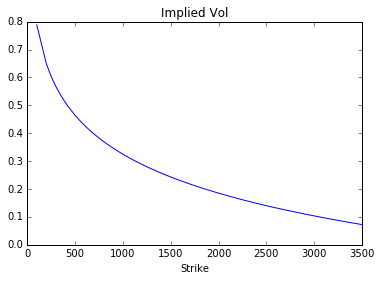

In [19]:
plt.figure()
plt.plot(K,sig)
plt.title('Implied Vol')
plt.xlabel('Strike')

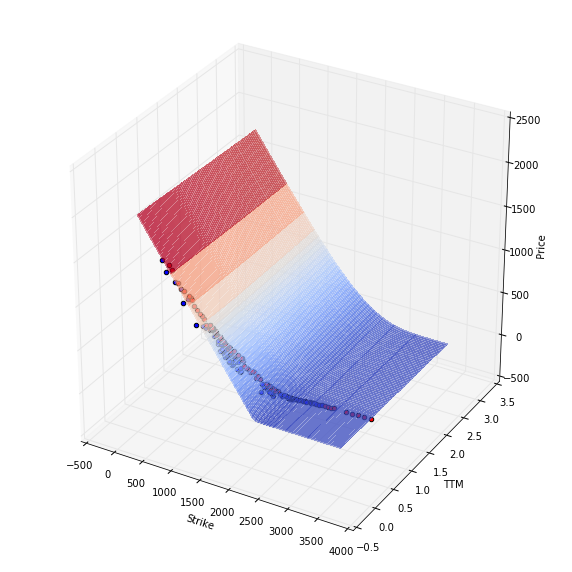

In [20]:
# Plot Call
X,Y =np.meshgrid(K,T)
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, fit_surface, cmap=cm.coolwarm, alpha=0.5,\
                       linewidth=0, antialiased=False)
# surface
plt.xlabel('Strike')
plt.ylabel('TTM')
ax.set_zlabel('Price')

#scatter
Call.index=T
Call.columns=K
fit_surface=pd.DataFrame(fit_surface, index=T,columns=K)
for t,k in zip(T,K):
    if ~np.isnan(Call.loc[t,k]):
        if Call.loc[t,k]>fit_surface.loc[t,k]:
            ax.scatter(k, t, Call.loc[t,k], c='r')
        else:
            ax.scatter(k, t, Call.loc[t,k], c='b')
            
plt.show()

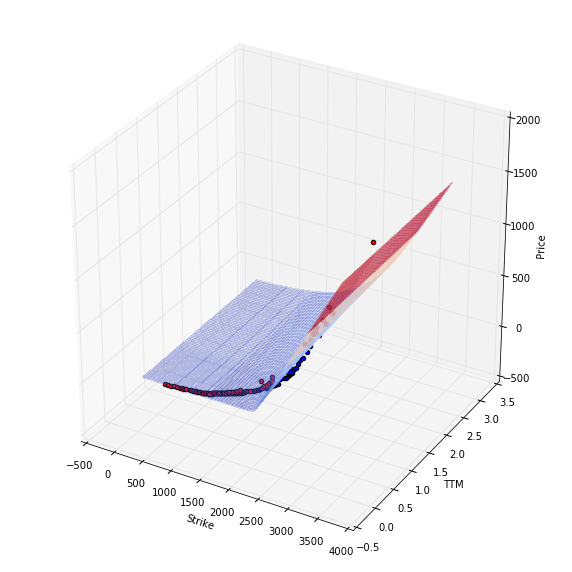

In [21]:
# Plot Put
fit_surface=BS(sig, res.x[3],res.x[4], S,K,T,opt='P')
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, fit_surface, cmap=cm.coolwarm, alpha=0.2,\
                       linewidth=0, antialiased=False)
# surface
plt.xlabel('Strike')
plt.ylabel('TTM')
ax.set_zlabel('Price')

#scatter
Put.index=T
Put.columns=K
fit_surface=pd.DataFrame(fit_surface, index=T,columns=K)
for t,k in zip(T,K):
    if ~np.isnan(Put.loc[t,k]):
        if Put.loc[t,k]>fit_surface.loc[t,k]:
            ax.scatter(k, t, Put.loc[t,k], c='r')
        else:
            ax.scatter(k, t, Put.loc[t,k], c='b')
            
plt.show()

In [22]:
del fit_surface
del sig

## Greeks and AD Securities

In [23]:
def Greeks(sig_fun, r, q, S,K,T):
    M=K.shape[0]
    N=T.shape[0]
    K=repmat(np.array(K).reshape([1,-1]),N,1)
    T=repmat(np.array(T).reshape([-1,1]),1,M)
    sig=sig_fun(S,K)
    d1=(np.log(S/K)+(r-q+sig**2/2)*T)/(sig*np.sqrt(T))
    d2=(np.log(S/K)+(r-q-sig**2/2)*T)/(sig*np.sqrt(T))
    # The necessary Greeks to calculate AD price
    Dual_Gamma = np.exp(-r*T)*norm.pdf(d2)/(K*sig*np.sqrt(T))
    Dual_Vanna = np.exp(-r*T)*norm.pdf(d2)*d1/sig
    Vega = K*np.exp(-r*T)*norm.pdf(d2)*np.sqrt(T)
    Vomma = Vega*d1*d2/sig
    return Dual_Gamma,Dual_Vanna,Vega, Vomma

# return the derivative of implied vol to strike
def sig_K(S,K,a,b): #implied vol=a+b*ln(S/K)+c*ln(S/K)^2
    first=-a/K-2*b*np.log(S/K)/K
    second=K**(-2)*(a+2*b*(1+np.log(S/K)))
    return first, second

In [24]:
sig_fun=lambda S,K: implied_vol(res.x[0],res.x[1],res.x[2],S,K)
Dual_Gamma,Dual_Vanna,Vega, Vomma=Greeks(sig_fun,res.x[3],res.x[4],S, K,T)
# Black Scholes Bench Mark
BS_fun=lambda S,K: 0.2
Dual_Gamma2,Dual_Vanna2,Vega2, Vomma2=Greeks(BS_fun,res.x[3],res.x[4],S, K,T)

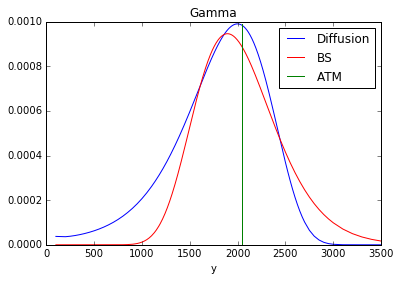

In [25]:
# Plot State Price at 1.16 year
plt.figure()
plt.plot(K,Dual_Gamma[400,:])
plt.plot(K,Dual_Gamma2[400,:],'r')
plt.plot(2050*np.ones([50,1]), np.linspace(0,max(Dual_Gamma[400,:]),50),'-')
plt.xlabel('y')
plt.title('Gamma')
plt.legend(['Diffusion', 'BS','ATM'],loc=0)
plt.show()

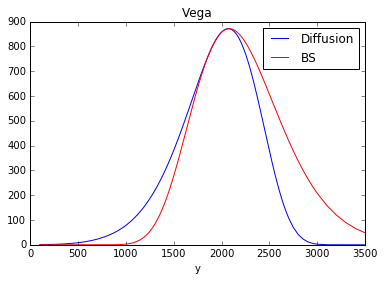

In [26]:
plt.figure()
plt.plot(K,Vega[400,:])
plt.plot(K,Vega2[400,:],'r')
plt.xlabel('y')
plt.title('Vega')
plt.legend(['Diffusion', 'BS'],loc=0)
plt.show()

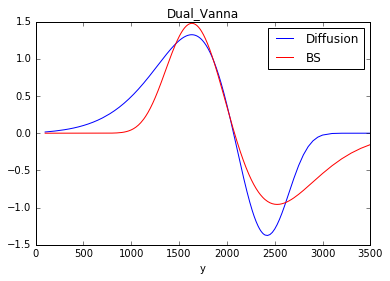

In [27]:
plt.figure()
plt.plot(K,Dual_Vanna[400,:])
plt.plot(K,Dual_Vanna2[400,:],'r')
plt.xlabel('y')
plt.title('Dual_Vanna')
plt.legend(['Diffusion', 'BS'],loc=0)
plt.show()

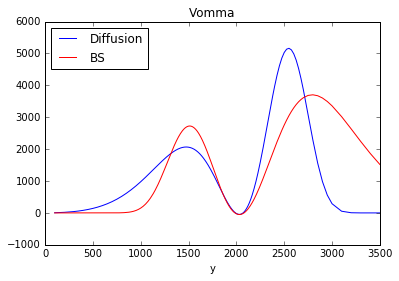

In [28]:
plt.figure()
plt.plot(K,Vomma[400,:])
plt.plot(K,Vomma2[400,:],'r')
plt.xlabel('y')
plt.title('Vomma')
plt.legend(['Diffusion', 'BS'],loc=0)
plt.show()

### Calculate State Price

In [29]:
def State_Price(sig_0,a,b, r, q, S,K,T):
    M=K.shape[0]
    N=T.shape[0]
    sig_fun=lambda s,k: implied_vol(sig_0,a,b,s,k)
    # Calculate Intermediate Terms
    Dual_Gamma,Dual_Vanna,Vega, Vomma=Greeks(sig_fun,r,q,S, K,T)
    first, second=sig_K(S,K,a,b)
    return Dual_Gamma+Dual_Vanna*first+Vega*second+Vomma*first*first

In [30]:
AD=State_Price(res.x[0],res.x[1],res.x[2], res.x[3], res.x[4], S,K,T)

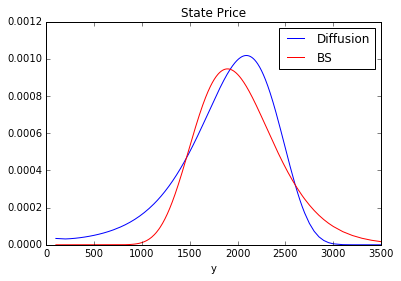

In [31]:
plt.figure()
plt.plot(K,AD[400,:])
plt.plot(K,Dual_Gamma2[400,:],'r')
plt.xlabel('y')
plt.title('State Price')
plt.legend(['Diffusion', 'BS'],loc=0)
plt.show()